### Load Library

In [94]:
import pandas as pd
import numpy as np

from string import punctuation, ascii_lowercase, digits
from nltk.stem.snowball import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor

from datasets import load_dataset
from sklearn.model_selection import train_test_split


import fasttext
import tempfile
import os

from sklearn.metrics import classification_report
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pickle


### Import Dataset

In [3]:
# Load the Yahoo! Answers Topic Classification dataset
dataset = load_dataset("yahoo_answers_topics")

train = dataset['train'].to_pandas()
train = train.drop(columns='id')

## Data Wrangling

### Remove special characters and punctuations

In [4]:
stopwordsSet = set(stopwords.words("english"))

# Create translation table for character filtering once
CHAR_MAP = str.maketrans('', '', punctuation)
VALID_CHARS = set(ascii_lowercase + digits + ' ')

# Compile regex pattern for multiple spaces
SPACE_PATTERN = re.compile(r'\s+')

@lru_cache(maxsize=200000)
def clean_text(content):
    """
    Clean text by converting to lowercase, removing punctuation and stopwords.
    Uses translation tables and caching for better performance.
    """
    # Convert to lowercase
    content = content.lower()
    
    # Remove punctuation using translation table
    content = content.translate(CHAR_MAP)
    
    # Keep only valid characters (faster than checking each character)
    content = ''.join(c for c in content if c in VALID_CHARS)
    
    # Replace multiple spaces with single space and split
    words = SPACE_PATTERN.sub(' ', content).split()
    
    # Filter stopwords
    return ' '.join(w for w in words if w not in stopwordsSet)

def batch_clean_texts(texts, batch_size=20000):
    """
    Clean multiple texts in parallel using batches.
    """
    # Split texts into batches
    batches = np.array_split(texts, max(1, len(texts) // batch_size))
    
    # Process batches in parallel
    with ThreadPoolExecutor() as executor:
        processed_batches = list(executor.map(
            lambda batch: [clean_text(str(text)) for text in batch],
            batches
        ))
    
    # Flatten results
    return [text for batch in processed_batches for text in batch]


In [5]:
train.question_title = batch_clean_texts(train.question_title.values)
train.question_content = batch_clean_texts(train.question_content.values)
train.best_answer = batch_clean_texts(train.best_answer.values)

In [6]:
# Example of website rows
# pd.set_option('display.max_colwidth', None)
selected_rows = train.iloc[6:8]
selected_rows

,topic,question_title,question_content,best_answer
6,1,people blush embarrassed,people blush embarrassed,ask yahoonhttpaskyahoocomask20040113htmlnblush...
7,7,lin qingxia aka brigitte lin beautiful woman c...,according stephen chow httpwwwhkentreviewcom20...,well everyone different definition beauty like...


In [7]:
# Example of mathmatical formula rows
selected_math_rows = train.iloc[15:16]
selected_math_rows[['best_answer']]

,best_answer
15,imaginary numbers numbers squared equal negati...


In [8]:
train

,topic,question_title,question_content,best_answer
0,4,doesnt optical mouse work glass table,even surfaces,optical mice use led camera rapidly capture im...
1,5,best offroad motorcycle trail,longdistance trail throughout ca,hear mojave road amazingbr nsearch online
2,2,trans fat reduce,heard tras fat bad body find daily food,trans fats occur manufactured foods process pa...
3,6,many planes fedex,heard largest airline world,according wwwfedexcom web sitenair fleetbr n b...
4,6,san francisco bay area make sense rent buy,prices rent price buying make sense mostly ren...,renting vs buying depends goals br ngenerally ...
...,...,...,...,...
1399995,2,ads tv yoko etc regarding height increase use,,increased height 2 feet afterwards yesnnof cou...
1399996,6,ways sell video games,like want sell video games sell,ebay electronic boutique babbages flea markets
1399997,2,normal nots breast boobs,,normal long cancerous breasts examined every 6...
1399998,0,speak hindi,write,main hindi bol sakti hoonkahiye


### Visualize frequent words

In [9]:
# # Words in question title
# question_titles = " ".join(s for s in train.question_title)
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_titles)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [10]:
# # Words in question content
# question_contents = " ".join(s for s in train.question_content)
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_contents)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [11]:
# # Sample 20% of the words in answers
# sample_answers = " ".join(s for s in train.best_answer.sample(frac=0.2, random_state=42))
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_answers)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [12]:
# Create a topic mapping of label and name
topic_mapping = {
    0: "Society & Culture",
    1: "Science & Mathematics",
    2: "Health",
    3: "Education & Reference",
    4: "Computers & Internet",
    5: "Sports",
    6: "Business & Finance",
    7: "Entertainment & Music",
    8: "Family & Relationships",
    9: "Politics & Government"
}

train['topic_name'] = train['topic'].map(topic_mapping)

In [13]:
# check number of records for each topic
topic_counts = train['topic_name'].value_counts()
topic_counts

topic_name
Computers & Internet      140000
Sports                    140000
Health                    140000
Business & Finance        140000
Science & Mathematics     140000
Entertainment & Music     140000
Education & Reference     140000
Family & Relationships    140000
Politics & Government     140000
Society & Culture         140000
Name: count, dtype: int64

### Check Empty Values and Combine Columns

In [14]:
# check NaN
train_copy = train.copy()
train_copy.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_copy.isna().sum()
nan_counts

topic                    0
question_title        4183
question_content    635515
best_answer          31120
topic_name               0
dtype: int64

In [15]:
# Combine Question title and question content together
combine = train.copy()
combine['question'] = combine['question_title'] + ' ' + combine['question_content']
combine = combine.drop(columns=['question_title', 'question_content'])

In [16]:
combine.head()

,topic,best_answer,topic_name,question
0,4,optical mice use led camera rapidly capture im...,Computers & Internet,doesnt optical mouse work glass table even sur...
1,5,hear mojave road amazingbr nsearch online,Sports,best offroad motorcycle trail longdistance tra...
2,2,trans fats occur manufactured foods process pa...,Health,trans fat reduce heard tras fat bad body find ...
3,6,according wwwfedexcom web sitenair fleetbr n b...,Business & Finance,many planes fedex heard largest airline world
4,6,renting vs buying depends goals br ngenerally ...,Business & Finance,san francisco bay area make sense rent buy pri...


In [17]:
combine.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = combine.isna().sum()
nan_counts

topic              0
best_answer    31120
topic_name         0
question         328
dtype: int64

In [18]:
# drop all NaNs from train dataset
train_clean = combine.dropna().copy()
train_clean.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_clean.isna().sum()
nan_counts

topic          0
best_answer    0
topic_name     0
question       0
dtype: int64

In [19]:
train_clean.shape

(1368590, 4)

### Check Duplicates

In [20]:
duplicate_count = train_clean.duplicated(subset=['topic', 'question', 'best_answer']).sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 297


In [21]:
# drop duplicates
train_clean_no_duplicates = train_clean.drop_duplicates(subset=['topic', 'question', 'best_answer']).reset_index(drop=True)

In [22]:
len(train_clean_no_duplicates)

1368293

In [23]:
# check number of records for each topic
topic_counts = train_clean_no_duplicates['topic_name'].value_counts()
topic_counts = pd.DataFrame(topic_counts)

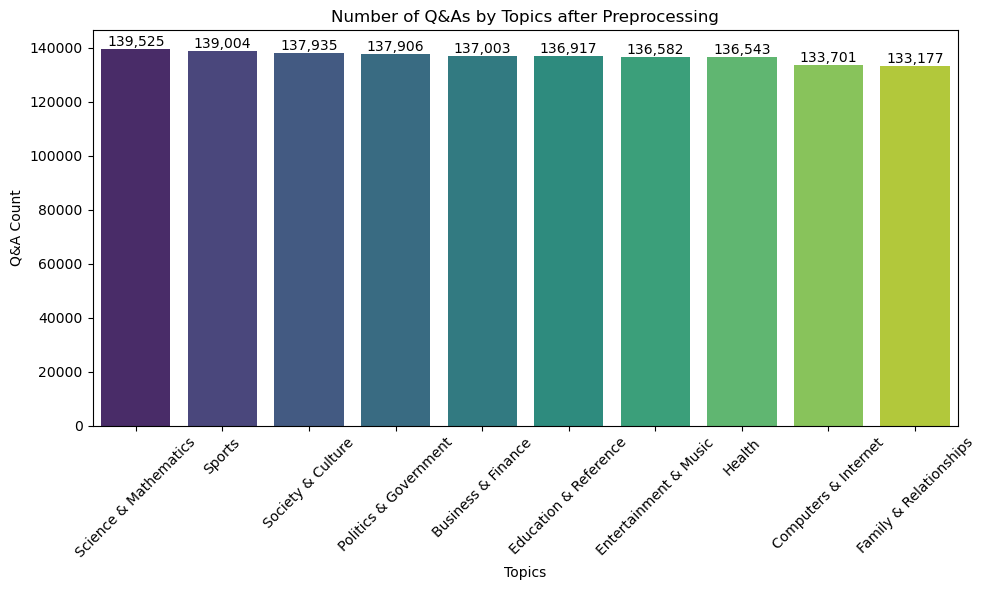

In [24]:
# Plot the total count of Q&As per topic
plt.figure(figsize=(10, 6))
sns.barplot(x='topic_name', y='count', hue='topic_name', data=topic_counts, palette='viridis')

plt.xlabel('Topics')
plt.ylabel('Q&A Count')
plt.title('Number of Q&As by Topics after Preprocessing')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(topic_counts['count']):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Train test split

In [25]:
X = train_clean_no_duplicates.drop(columns=['topic', 'topic_name'])
y = train_clean_no_duplicates['topic']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
len(X_train)

1094634

In [27]:
len(y_train)

1094634

In [28]:
len(X_val)

273659

In [29]:
len(y_val)

273659

In [30]:
X_train.head()

,best_answer,question
1170758,play simonsays command wipe nose,proper way let someone talking know booger han...
1238600,figos wife,sexiest wife footballer world cup 2006
707981,liverpool rules,curious ever read team history liverpools 3 tr...
207846,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...
1315775,looks like carolina hurricanes going win 31 se...,win stanley cup


In [31]:
X_val.head()

,best_answer,question
210868,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...
332397,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...
1287631,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...
590830,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...
255960,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling


### Fast Text Classification


In [32]:
train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_combined = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)


In [33]:
print(len(train_combined))
print(len(val_combined))

1094634
273659


In [34]:
train_combined['category'] = "__label__" + train_combined['topic'].astype(str)
val_combined['category'] = "__label__" + val_combined['topic'].astype(str)


#### FastText Classification using question

In [35]:
train_combined['category_question'] = train_combined['category'] + " " + train_combined['question']
train_combined

,best_answer,question,topic,category,category_question
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup
...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces


In [36]:
val_combined['category_question'] = val_combined['category'] + " " + val_combined['question']
val_combined

,best_answer,question,topic,category,category_question
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...
...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...


In [37]:
# save train and validation into txt format
train_combined.to_csv("FastText_question.train",columns=["category_question"],index=False,header=False)
val_combined.to_csv("FastText_question.val",columns=["category_question"],index=False,header=False)


In [38]:
# train fasttext classification model
question_model = fasttext.train_supervised(input="FastText_question.train")
question_model.test("FastText_question.val")

Read 20M words
Number of words:  782272
Number of labels: 10
Progress: 100.0% words/sec/thread: 3608352 lr:  0.000000 avg.loss:  1.011568 ETA:   0h 0m 0s


(273659, 0.7022352635944734, 0.7022352635944734)

In [39]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_question.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [question_model.predict(text)[0][0] for text in validation_data]

In [40]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7022352635944734
Macro Precision: 0.6995311489539411
Macro Recall: 0.7025739455010236
Macro F1-score: 0.7005407107142652


In [41]:
# # Define parameter options
# parameter_options = {
#     "epoch": [5, 10, 15],
#     "lr": [0.1, 0.3, 0.5],
#     "wordNgrams": [1, 2],
#     "dim": [100, 200],
#     "loss": ["softmax", "ova"]
# }


In [42]:
# # Generate all combinations of parameters
# parameter_combinations = list(itertools.product(
#     parameter_options["epoch"],
#     parameter_options["lr"],
#     parameter_options["wordNgrams"],
#     parameter_options["dim"],
#     parameter_options["loss"]
# ))

In [43]:
# results = []

# for params in parameter_combinations:
#     epoch, lr, wordNgrams, dim, loss = params

#     model = fasttext.train_supervised(
#         input="FastText_all.train",
#         epoch=epoch,
#         lr=lr,
#         wordNgrams=wordNgrams,
#         dim=dim,
#         loss=loss
#     )

#     # Predict on validation data
#     predicted_labels = [model.predict(text)[0][0] for text in validation_data]

#     # Compute metrics
#     report = classification_report(true_labels, predicted_labels, output_dict=True)
#     accuracy = report["accuracy"]
#     macro_precision = report["macro avg"]["precision"]
#     macro_recall = report["macro avg"]["recall"]
#     macro_f1 = report["macro avg"]["f1-score"]

#     # Store results
#     results.append({
#         "epoch": epoch,
#         "lr": lr,
#         "wordNgrams": wordNgrams,
#         "dim": dim,
#         "loss": loss,
#         "accuracy": accuracy,
#         "macro_precision": macro_precision,
#         "macro_recall": macro_recall,
#         "macro_f1": macro_f1
#     })

#     print(f"Completed combination: {params}")

# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by="macro_f1", ascending=False)

In [44]:
# results_df

#### FastText Classification using best_answer

In [45]:
train_combined['category_best_answer'] = train_combined['category'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...,__label__0 play simonsays command wipe nose
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...,__label__5 figos wife
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...,__label__5 liverpool rules
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...,__label__9 believe illegitimate rule simply si...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup,__label__5 looks like carolina hurricanes goin...
...,...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol,__label__3 rather yummy
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...,__label__1 progeria
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...,__label__9 thats called dignitymost politician...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces,__label__0 course want rights straight people


In [46]:
val_combined['category_best_answer'] = val_combined['category'] + " " + val_combined['best_answer']
val_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...,__label__5 heres one cartoon surfer hanging 10...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...,__label__0 1 ancient people technical knowledg...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...,__label__6 wow good question doubt oman united...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...,__label__4 httpwwwopencmsorgopencmsen main sit...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...,__label__5 water pump fuel pump sometimes tick...
...,...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...,__label__3 plot quadratic formula cartesian co...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...,__label__8 presume boyfriend age well sit does...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...,__label__1 assuming asking rods fully withdraw...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...,__label__2 would want middle head kind mohawk ...


In [47]:
# save train and validation into txt format
train_combined.to_csv("FastText_best_answer.train",columns=["category_best_answer"],index=False,header=False)
val_combined.to_csv("FastText_best_answer.val",columns=["category_best_answer"],index=False,header=False)


In [48]:
# train fasttext classification model
best_answer_model = fasttext.train_supervised(input="FastText_best_answer.train")
best_answer_model.test("FastText_best_answer.val")

Read 37M words
Number of words:  1698041
Number of labels: 10
Progress: 100.0% words/sec/thread: 4579521 lr:  0.000000 avg.loss:  1.320912 ETA:   0h 0m 0s


(273659, 0.600086238713143, 0.600086238713143)

In [49]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_best_answer.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [best_answer_model.predict(text)[0][0] for text in validation_data]

In [50]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.600086238713143
Macro Precision: 0.5995268431783851
Macro Recall: 0.6004517628516082
Macro F1-score: 0.5988255343514141


#### FastText Classification using best_answer and question

In [51]:
train_combined['category_all'] = train_combined['category'] + " " + train_combined['question'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...,__label__0 play simonsays command wipe nose,__label__0 proper way let someone talking know...
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...,__label__5 figos wife,__label__5 sexiest wife footballer world cup 2...
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...,__label__5 liverpool rules,__label__5 curious ever read team history live...
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...,__label__9 believe illegitimate rule simply si...,__label__9 illegitimate rule body help thanks ...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup,__label__5 looks like carolina hurricanes goin...,__label__5 win stanley cup looks like carolin...
...,...,...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol,__label__3 rather yummy,__label__3 alcohol rather yummy
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...,__label__1 progeria,__label__1 disease age body doesntyou look 12 ...
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...,__label__9 thats called dignitymost politician...,__label__9 kinky friedman candidate isnt bashi...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces,__label__0 course want rights straight people,__label__0 think gays able serve armed forces ...


In [52]:
val_combined['category_all'] = val_combined['category'] + " " + val_combined['question'] + " " + val_combined['best_answer']

val_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...,__label__5 heres one cartoon surfer hanging 10...,__label__5 want pictures ocean waves comes bea...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...,__label__0 1 ancient people technical knowledg...,__label__0 turnquestions religious 1 would peo...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...,__label__6 wow good question doubt oman united...,__label__6 new villa development would buy ass...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...,__label__4 httpwwwopencmsorgopencmsen main sit...,__label__4 information opencms get good inform...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...,__label__5 water pump fuel pump sometimes tick...,__label__5 clk320 engine ticking noise car idl...
...,...,...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...,__label__3 plot quadratic formula cartesian co...,__label__3 quadratic formula relates graph par...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...,__label__8 presume boyfriend age well sit does...,__label__8 weird things guys boyfriends seems ...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...,__label__1 assuming asking rods fully withdraw...,__label__1 controll rods pulled nuclear power ...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...,__label__2 would want middle head kind mohawk ...,__label__2 got 8 strands hair left would want ...


In [53]:
# save train and validation into txt format
train_combined.to_csv("FastText_all.train",columns=["category_all"],index=False,header=False)
val_combined.to_csv("FastText_all.val",columns=["category_all"],index=False,header=False)


In [54]:
# train fasttext classification model
best_answer_model = fasttext.train_supervised(input="FastText_all.train")
best_answer_model.test("FastText_all.val")

Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5127543 lr:  0.000000 avg.loss:  0.953700 ETA:   0h 0m 0s100.0% words/sec/thread: 5127599 lr: -0.000000 avg.loss:  0.953700 ETA:   0h 0m 0s


(273659, 0.7139651902550254, 0.7139651902550254)

In [55]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_all.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [best_answer_model.predict(text)[0][0] for text in validation_data]

In [56]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7139651902550254
Macro Precision: 0.7106024437363071
Macro Recall: 0.7142568374639715
Macro F1-score: 0.7116706197270493


### FastText as word Embedding

In [57]:
X_train.head()

,best_answer,question
1170758,play simonsays command wipe nose,proper way let someone talking know booger han...
1238600,figos wife,sexiest wife footballer world cup 2006
707981,liverpool rules,curious ever read team history liverpools 3 tr...
207846,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...
1315775,looks like carolina hurricanes going win 31 se...,win stanley cup


In [58]:
# save train and validation into txt format
X_train.to_csv("FastText_question_emd.train",columns=["question"],index=False,header=False)
X_val.to_csv("FastText_question_emd.val",columns=["question"],index=False,header=False)

In [79]:
X_train_all = X_train.copy()
X_val_all = X_val.copy()

X_train_all['question_answer'] = X_train_all['question'] + " " + X_train_all['best_answer']
X_val_all['question_answer'] = X_val_all['question'] + " " + X_val_all['best_answer']

In [80]:
# save train and validation into txt format
X_train_all.to_csv("FastText_all_emd.train",columns=["question_answer"],index=False,header=False)
X_val_all.to_csv("FastText_all_emd.val",columns=["question_answer"],index=False,header=False)

#### FastText Embedding Questions

In [59]:
X_train_question = X_train[['question']]
X_val_question = X_val[['question']]

In [60]:
train_labels = y_train.copy()
val_labels = y_val.copy()

In [61]:
# Train FastText to generate word embeddings
# question_emd_model = fasttext.train_unsupervised("FastText_question_emd.train", model="skipgram")

Read 18M words
Number of words:  84510
Number of labels: 0
Progress: 100.0% words/sec/thread:  116733 lr:  0.000000 avg.loss:  1.556216 ETA:   0h 0m 0s


In [62]:
# all words in the vocabulary, sorted by decreasing frequency
# question_emd_model.words

['</s>',
 'know',
 'like',
 'get',
 'would',
 'im',
 'dont',
 'think',
 'help',
 'one',
 'want',
 'need',
 'people',
 'anyone',
 'really',
 'please',
 'good',
 'find',
 'go',
 'time',
 'make',
 'best',
 'u',
 'tell',
 'love',
 'cant',
 'way',
 'many',
 'much',
 'could',
 'work',
 '2',
 'someone',
 'us',
 'say',
 'going',
 'back',
 'see',
 'years',
 'question',
 'give',
 'still',
 'world',
 'take',
 'new',
 'also',
 'something',
 'use',
 'even',
 'name',
 'mean',
 'year',
 'got',
 'right',
 'feel',
 'old',
 'guy',
 'first',
 'answer',
 'day',
 'school',
 'whats',
 'said',
 'ever',
 'ive',
 'friend',
 'life',
 'looking',
 'girl',
 'never',
 'god',
 'person',
 'computer',
 'anything',
 'two',
 'come',
 'long',
 'better',
 'always',
 'things',
 'last',
 'friends',
 'free',
 'home',
 'man',
 'money',
 'thing',
 'well',
 '3',
 'bad',
 'doesnt',
 'told',
 'without',
 'song',
 'says',
 'live',
 'getting',
 'sex',
 'thanks',
 '1',
 'yahoo',
 'guys',
 'problem',
 'job',
 'put',
 'look',
 'anothe

In [63]:
# word vector
# question_emd_model.get_word_vector("know")

array([-6.43789470e-02,  9.76730064e-02, -3.38787735e-01,  1.81162640e-01,
       -5.47218770e-02, -1.33592322e-01,  5.24733309e-03, -2.07850456e-01,
        2.19691157e-01, -4.35375385e-02, -9.75479484e-02,  9.89491940e-02,
        3.25755239e-01,  1.48209557e-01, -3.04147333e-01, -1.51590794e-01,
        6.72664791e-02, -1.27852291e-01,  2.11626127e-01, -2.41880685e-01,
        8.88031349e-02,  6.17403351e-03,  1.22543275e-01, -5.88736637e-03,
        1.49349973e-01, -1.74789280e-02,  1.41772807e-01,  2.54044652e-01,
       -1.93168387e-01,  1.61542088e-01,  6.67951852e-02,  1.47633016e-01,
       -1.34572238e-01, -2.17558935e-01, -1.01409480e-01,  5.23222163e-02,
        2.05832094e-01, -1.26720101e-01, -1.58366337e-01,  3.63546044e-01,
        1.10667318e-01,  5.86851537e-02,  1.66022137e-01, -1.83452263e-01,
        2.04669699e-01, -4.86924388e-02, -7.27160648e-02, -5.38600311e-02,
       -1.88180342e-01,  4.68604192e-02, -9.01376754e-02,  1.62757888e-01,
       -9.01163518e-02,  

In [64]:
# save model
# question_emd_model.save_model("question_emd_model.bin")
# load model
question_emd_model = fasttext.load_model("question_emd_model.bin")


In [65]:
X_train_question_list = X_train_question['question'].tolist()
X_val_question_list = X_val_question['question'].tolist()

In [66]:
# def get_sentence_embedding(sentence, model):
#     """
#     Generate sentence embedding by averaging word vectors.
#     """
#     words = sentence.split()
#     word_vectors = [model[word] for word in words if word in model]
#     return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.get_dimension())

# # Step 3: Prepare training and validation data
# # Assume `train_texts`, `val_texts`, `train_labels`, and `val_labels` are preloaded lists
# # Convert texts to embeddings
# X_train_question_emd = np.array([get_sentence_embedding(text, question_emd_model) for text in X_train_question_list])
# X_val_question_emd = np.array([get_sentence_embedding(text, question_emd_model) for text in X_val_question_list])

In [67]:
# X_train_question_emd.shape

In [68]:
# X_val_question_emd.shape

In [69]:

# X_train_question_emd_df = pd.DataFrame(X_train_question_emd)
# X_val_question_emd_df = pd.DataFrame(X_val_question_emd)

# # Save as CSV files
# X_train_question_emd_df.to_csv('question_train_emd.csv', index=False)
# X_val_question_emd_df.to_csv('question_val_emd.csv', index=False)

# To load the data back into NumPy arrays
X_train_question_emd = pd.read_csv('question_train_emd.csv').values
X_val_question_emd = pd.read_csv('question_val_emd.csv').values

In [70]:
# For Naive Bayes (requires sparse data like TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_question_list)
X_val_tfidf = tfidf_vectorizer.transform(X_val_question_list)

In [75]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # "Naive Bayes (TF-IDF)": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "SVM": SVC(kernel='linear', probability=True)
}

In [76]:
results = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name == "Naive Bayes (TF-IDF)":
        # Train using TF-IDF features
        model.fit(X_train_tfidf, train_labels)
        preds = model.predict(X_val_tfidf)
    else:
        # Train using embeddings
        model.fit(X_train_question_emd, train_labels)
        preds = model.predict(X_val_question_emd)

    # Evaluate model
    report = classification_report(val_labels, preds, output_dict=True)
    accuracy = report["accuracy"]
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1-score": macro_f1
    })

    print(f"Completed {model_name}")

# Step 6: Display and compare results
results_df = pd.DataFrame(results).sort_values(by="Macro F1-score", ascending=False)

Training Logistic Regression...
Completed Logistic Regression
Training Random Forest...
Completed Random Forest


In [77]:
results_df

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score
1,Random Forest,0.684578,0.679819,0.684925,0.680601
0,Logistic Regression,0.675651,0.671499,0.676141,0.672279


#### FastText Embedding Question and Best Answer


In [81]:
X_train_all = X_train_all[['question_answer']]
X_val_all = X_val_all[['question_answer']]

In [82]:
train_labels = y_train.copy()
val_labels = y_val.copy()

In [83]:
# Train FastText to generate word embeddings
all_emd_model = fasttext.train_unsupervised("FastText_all_emd.train", model="skipgram")

Read 53M words
Number of words:  194484
Number of labels: 0
Progress: 100.0% words/sec/thread:   85000 lr:  0.000000 avg.loss:  0.688194 ETA:   0h 0m 0s


In [ ]:
# all words in the vocabulary, sorted by decreasing frequency
# question_emd_model.words

['</s>',
 'know',
 'like',
 'get',
 'would',
 'im',
 'dont',
 'think',
 'help',
 'one',
 'want',
 'need',
 'people',
 'anyone',
 'really',
 'please',
 'good',
 'find',
 'go',
 'time',
 'make',
 'best',
 'u',
 'tell',
 'love',
 'cant',
 'way',
 'many',
 'much',
 'could',
 'work',
 '2',
 'someone',
 'us',
 'say',
 'going',
 'back',
 'see',
 'years',
 'question',
 'give',
 'still',
 'world',
 'take',
 'new',
 'also',
 'something',
 'use',
 'even',
 'name',
 'mean',
 'year',
 'got',
 'right',
 'feel',
 'old',
 'guy',
 'first',
 'answer',
 'day',
 'school',
 'whats',
 'said',
 'ever',
 'ive',
 'friend',
 'life',
 'looking',
 'girl',
 'never',
 'god',
 'person',
 'computer',
 'anything',
 'two',
 'come',
 'long',
 'better',
 'always',
 'things',
 'last',
 'friends',
 'free',
 'home',
 'man',
 'money',
 'thing',
 'well',
 '3',
 'bad',
 'doesnt',
 'told',
 'without',
 'song',
 'says',
 'live',
 'getting',
 'sex',
 'thanks',
 '1',
 'yahoo',
 'guys',
 'problem',
 'job',
 'put',
 'look',
 'anothe

In [ ]:
# word vector
# question_emd_model.get_word_vector("know")

array([-6.43789470e-02,  9.76730064e-02, -3.38787735e-01,  1.81162640e-01,
       -5.47218770e-02, -1.33592322e-01,  5.24733309e-03, -2.07850456e-01,
        2.19691157e-01, -4.35375385e-02, -9.75479484e-02,  9.89491940e-02,
        3.25755239e-01,  1.48209557e-01, -3.04147333e-01, -1.51590794e-01,
        6.72664791e-02, -1.27852291e-01,  2.11626127e-01, -2.41880685e-01,
        8.88031349e-02,  6.17403351e-03,  1.22543275e-01, -5.88736637e-03,
        1.49349973e-01, -1.74789280e-02,  1.41772807e-01,  2.54044652e-01,
       -1.93168387e-01,  1.61542088e-01,  6.67951852e-02,  1.47633016e-01,
       -1.34572238e-01, -2.17558935e-01, -1.01409480e-01,  5.23222163e-02,
        2.05832094e-01, -1.26720101e-01, -1.58366337e-01,  3.63546044e-01,
        1.10667318e-01,  5.86851537e-02,  1.66022137e-01, -1.83452263e-01,
        2.04669699e-01, -4.86924388e-02, -7.27160648e-02, -5.38600311e-02,
       -1.88180342e-01,  4.68604192e-02, -9.01376754e-02,  1.62757888e-01,
       -9.01163518e-02,  

In [84]:
# save model
all_emd_model.save_model("all_emd_model.bin")
# load model
# question_emd_model = fasttext.load_model("question_emd_model.bin")


In [85]:
X_train_all_list = X_train_all['question_answer'].tolist()
X_val_all_list = X_val_all['question_answer'].tolist()

In [86]:
def get_sentence_embedding(sentence, model):
    """
    Generate sentence embedding by averaging word vectors.
    """
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.get_dimension())


X_train_all_emd = np.array([get_sentence_embedding(text, all_emd_model) for text in X_train_all_list])
X_val_all_emd = np.array([get_sentence_embedding(text, all_emd_model) for text in X_val_all_list])

In [87]:
X_train_all_emd.shape

(1094634, 100)

In [88]:
X_val_all_emd.shape

(273659, 100)

In [89]:

X_train_all_emd_df = pd.DataFrame(X_train_all_emd)
X_val_all_emd_df = pd.DataFrame(X_val_all_emd)

# Save as CSV files
X_train_all_emd_df.to_csv('all_train_emd.csv', index=False)
X_val_all_emd_df.to_csv('all_val_emd.csv', index=False)

# # To load the data back into NumPy arrays
# X_train_all_emd = pd.read_csv('all_train_emd.csv').values
# X_val_all_emd = pd.read_csv('all_val_emd.csv').values

In [90]:
# For Naive Bayes (requires sparse data like TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_all = tfidf_vectorizer.fit_transform(X_train_all_list)
X_val_tfidf_all = tfidf_vectorizer.transform(X_val_all_list)

In [91]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes (TF-IDF)": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "SVM": SVC(kernel='linear', probability=True)
}

In [95]:
results = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name == "Naive Bayes (TF-IDF)":
        # Train using TF-IDF features
        model.fit(X_train_tfidf_all, train_labels)
        preds = model.predict(X_val_tfidf_all)
    else:
        # Train using embeddings
        model.fit(X_train_all_emd, train_labels)
        preds = model.predict(X_val_all_emd)
    
    # Save the trained model
    model_filename = f"all_emd_{model_name.replace(' ', '_')}.bin"  # Replace spaces to avoid filename issues
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)  # Use pickle to save the model
    print(f"Model saved as {model_filename}")


    # Evaluate model
    report = classification_report(val_labels, preds, output_dict=True)
    accuracy = report["accuracy"]
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1-score": macro_f1
    })

    print(f"Completed {model_name}")

# Step 6: Display and compare results
emd_all_results_df = pd.DataFrame(results).sort_values(by="Macro F1-score", ascending=False)

# load the model
# with open("all_emd_ModelName.bin", "rb") as f:
#     model = pickle.load(f)

Training Logistic Regression...
Model saved as all_emd_Logistic_Regression.bin
Completed Logistic Regression
Training Naive Bayes (TF-IDF)...
Model saved as all_emd_Naive_Bayes_(TF-IDF).bin
Completed Naive Bayes (TF-IDF)
Training Random Forest...
Model saved as all_emd_Random_Forest.bin
Completed Random Forest


In [96]:
emd_all_results_df

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score
2,Random Forest,0.700686,0.695850,0.700981,0.696654
0,Logistic Regression,0.697715,0.693313,0.698086,0.694293
1,Naive Bayes (TF-IDF),0.663274,0.660860,0.663874,0.659989


In [97]:
emd_all_results_df.to_csv('emd_all_results.csv')